## Research question 1:

1. Are inhabitants of cities more likely to have more friends than individuals living in rural areas?

Plan to answer this question:

- how many people define a city? Drop cities with less inhabitants, less population density
- convert area to radius
- for each country:
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes
- calculate # friends per user, group by rural/city and compare amount of friends

### Libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from poisson_etest import poisson_etest
from sklearn.linear_model import LinearRegression
from geopy.distance import distance
from functions import load_data

### Load the data


#### Load home locations

In [12]:
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")

B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)

In [13]:
# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

#### Load cities

In [205]:
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_"
cities = pd.read_csv("city_and_area.csv").drop(columns = ['Unnamed: 0'], axis = 1)
cities = cities.drop(columns = ['capital', 'admin_name'], axis = 1)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_


In [206]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.07
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.50
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.00
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.00
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.82


#### Load edges

In [118]:
%cd "/home/mogan/Desktop"
_, B_edges = load_data("Brightkite")
_, G_edges = load_data("Gowalla")

/home/mogan/Desktop


### Deal with the cities

1. Calculate population density
2. Drop cities with # inhabitants < 50.000 and population density < 1500 ([How we define cities](https://blogs.worldbank.org/sustainablecities/how-do-we-define-cities-towns-and-rural-areas))
       The Degree of Urbanization identifies cities as cities, if they have a population of at least 50,000 inhabitants in contiguous dense grid cells (>1,500 inhabitants per km2);
3. Calculate the radius for each city


In [195]:
cities = cities.drop(columns=['city_ascii', 'iso3', 'id'], axis=1)
cities.head()

,city,lat,lng,country,iso2,population,area
0,Tokyo,35.6897,139.6922,Japan,JP,37977000.0,2194.07
1,Jakarta,-6.2146,106.8451,Indonesia,ID,34540000.0,7062.50
2,Delhi,28.6600,77.2300,India,IN,29617000.0,1484.00
3,Mumbai,18.9667,72.8333,India,IN,23355000.0,4355.00
4,Manila,14.5958,120.9772,Philippines,PH,23088000.0,1474.82


In [196]:
# We had the impression that some US cities are missing in the cities data set, so we crawled another data set from wikipedia
# Wrangle us cities to fit to other cities
%cd "/home/mogan/Desktop"
us_cities = pd.read_csv("./data/us_cities.csv")
us_cities = us_cities.drop(columns=['2019rank', 'State[c]', '2010Census', 'Change', '2016 land area','2016 population density'])
us_cities = us_cities.rename(columns={'City':'city', '2019estimate':'population', '2016 land area.1':'area','2016 population density.1':'density' })
us_cities['population'] = us_cities['population'].str.replace(',','.')#.astype('float64')
us_cities['population'] = us_cities['population'].str.replace(r'\.', '').astype(float)
us_cities['city'] = us_cities['city'].str.replace(r'\[\w+\]', '')
us_cities['area'] = us_cities['area'].str.replace(r'\s\D+\d', '')
us_cities['area'] = us_cities['area'].str.replace(',','').astype(float)
us_cities['density'] = us_cities['density'].str.replace(r'/\D+\d', '')
us_cities['density'] = us_cities['density'].str.replace(',','').astype(float)
us_cities['Location'] = us_cities['Location'].str.split(r'/', expand = True)[1]
us_cities[['lat', 'lng']] = us_cities['Location'].str.split(r'\s', expand = True)[[1,2]]
us_cities = us_cities.drop(columns=['Location'], axis=1)
us_cities['lat'] = us_cities['lat'].str.replace('°N','').str.replace('\ufeff','').astype(float)
us_cities['lng'] = us_cities['lng'].str.replace('°W','').str.replace('\ufeff','').astype(float)
us_cities['iso2'] = 'US'
us_cities['country'] = 'United States'
us_cities

/home/mogan/Desktop


,city,population,area,density,lat,lng,iso2,country
0,New York City,8336817.0,780.9,10933.0,40.6635,73.9387,US,United States
1,Los Angeles,3979576.0,1213.9,3276.0,34.0194,118.4108,US,United States
2,Chicago,2693976.0,588.7,4600.0,41.8376,87.6818,US,United States
3,Houston,2320268.0,1651.1,1395.0,29.7866,95.3909,US,United States
4,Phoenix,1680992.0,1340.6,1200.0,33.5722,112.0901,US,United States
...,...,...,...,...,...,...,...,...
312,San Angelo,101004.0,155.1,649.0,31.4411,100.4505,US,United States
313,Vacaville,100670.0,75.1,1332.0,38.3539,121.9728,US,United States
314,Clinton,100471.0,72.8,1380.0,42.5903,82.9170,US,United States
315,Bend,100421.0,85.7,1171.0,44.0500,121.3000,US,United States


In [207]:
# 0. Estimate the missing areas for cities
n_cities = cities[cities['area'].isna()]
n_cities = n_cities[n_cities['population'] > 50000]

# Cannot predict for unknown population
n_cities = n_cities[~n_cities['population'].isnull()]

# Drop missing values for prediction
cities = cities[cities['population'] > 50000]
cities = cities[~cities['area'].isnull()]

In [208]:
# 1. Construct a linear model to estimate the missing areas
X = cities['population'].values.reshape(-1, 1)
y = cities['area'].values
reg = LinearRegression().fit(X, y)

# Predict the missing areas
pred_area = reg.predict(n_cities['population'].values.reshape(-1, 1))
n_cities['area'] = pred_area

# Merge city data
cities = cities.append(n_cities)

# 2. Calculate population density again for all data
cities['density'] = cities['population'] / cities['area']

In [199]:
# merge the city data
cities = cities.append(us_cities)
cities = cities[cities['population'] > 50000]

In [201]:
# 3. Calculate the radius for each city
def radius(A):
    return np.sqrt(A/np.pi)

cities['radius'] = cities['area'].apply(lambda x: radius(x))

In [211]:
cities

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area,density
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.07,17308.928156
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.50,4890.619469
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.00,19957.547170
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.00,5362.801378
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.82,15654.791771
...,...,...,...,...,...,...,...,...,...,...,...
11167,Traverse City,Traverse City,44.7547,-85.6035,United States,US,USA,50522.0,1840003946,8.66,5833.949192
11169,East Hartford,East Hartford,41.7634,-72.6152,United States,US,USA,50453.0,1840034618,18.70,2698.021390
11170,Irondequoit,Irondequoit,43.2096,-77.5705,United States,US,USA,50427.0,1840058201,16.82,2998.038050
11179,Mishawaka,Mishawaka,41.6736,-86.1669,United States,US,USA,50363.0,1840014695,17.97,2802.615470


In [210]:
# 4. Drop cities with # inhabitants < 50.000 and population density < 1500
cities = cities[(cities['population'] > 50000) & (cities['density'] > 1500)]
cities = cities.drop_duplicates()

In [10]:
# Save cities dataframe
cities.to_pickle("cities.pickle")

### Does user live in rural or urban area?

  for each country:
  
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes



In [35]:
# Take a subset for now
B_homes = B_homes.sample(4000, random_state=1)
G_homes = G_homes.sample(4000, random_state=1)

In [36]:
# Create a huge dataframe with all cities per country to then check if a home location is close to a city
B_merge = B_homes.merge(cities, left_on = 'country', right_on = 'iso2')
G_merge = G_homes.merge(cities, left_on = 'country', right_on = 'iso2')

In [40]:
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)

KeyboardInterrupt: 

In [ ]:
B_merge.head()

In [ ]:
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})

G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})

In [ ]:
# Integrate the 'lives_urban' variable into the home location datasets
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [ ]:
B_homes.head()
G_homes.head()

In [35]:
# Save intermediate results
# Save home locations
B_merge.to_pickle("B_merge_.pickle")
G_merge.to_pickle("G_merge_.pickle")

### Calculate # friends per user, group by rural/city and compare amount of friends


In [ ]:
B_friends = B_edges.groupby('from_id').count()
G_friends = G_edges.groupby('from_id').count()

In [ ]:
B_homes = B_homes.merge(B_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})
G_homes = G_homes.merge(G_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})

In [23]:
B_homes.head()

,longitude,latitude,country,user,lives_urban,#_friends
user_id,,,,,,
18790,-116.203451,43.613500,US,18790,True,1
50434,-2.966667,56.500000,GB,50434,False,2
52196,145.133333,-37.916667,AU,52196,False,1
26515,139.550000,35.683333,JP,26515,True,8
25999,139.678110,35.640909,JP,25999,True,10


### Compare amount of friends for urban/ rural users

In [ ]:
B_homes.groupby('lives_urban')['#_friends'].describe()

In [ ]:
G_homes.groupby('lives_urban')['#_friends'].describe()

In [ ]:
B_urban = B_homes[B_homes['lives_urban'] == True]
B_rural = B_homes[B_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(B_rural['#_friends'], label='rural', hist=False)
sns.distplot(B_urban['#_friends'], label='urban', hist=False)
plt.legend();

In [ ]:
G_urban = G_homes[G_homes['lives_urban'] == True]
G_rural = G_homes[G_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(G_rural['#_friends'], label='rural', hist=False)
sns.distplot(G_urban['#_friends'], label='urban', hist=False)
plt.legend();

### Statistical Test to investigate significant effect

We will perform a poisson-test to inspect whether the two samples stem from the same possion distribution. We assume $\alpha = 0.05$.

Check assumptions:
1. Underlying distribution is a poisson
2. estimate the four rates, $\lambda_{bk-urban}, \lambda_{bk-rural},\lambda_{gw-urban},\lambda_{gw-rural}$

All four distributions seems to be a bit more skewed than expected for a poisson distribution.


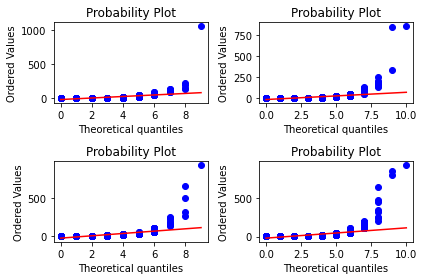

In [55]:
# 2. Inspect the distribution of the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

data = B_urban['#_friends']
stats.probplot(B_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax1)
stats.probplot(B_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax2)
stats.probplot(G_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax3)
stats.probplot(G_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax4)
fig.tight_layout()

print("All four distributions seems to be a bit more skewed than expected for a poisson distribution.")

In [36]:
sample1_k, sample1_n = B_urban['#_friends'].mean(), len(B_urban)
sample2_k, sample2_n = B_rural['#_friends'].mean(), len(B_rural)
poiss_p_1 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_1,6)}.")

Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.047074.


In [34]:
sample1_k, sample1_n = G_urban['#_friends'].mean(), len(G_urban)
sample2_k, sample2_n = G_rural['#_friends'].mean(), len(G_rural)
poiss_p_2 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_2,6)}.")

Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.042888.


TODO 
Do directional hypothesis

## OLD

In [37]:
# 1. Check for equal variances:
# The Levene test tests the null hypothesis that all input samples are from populations with equal variances.

#_, p1 = levene(B_urban['#_friends'], B_rural['#_friends'])
#_, p2 = levene(G_urban['#_friends'], G_rural['#_friends'])

#print(" p-value Brightkite:", p1, "\n", "p-value Gowalla:", p2, "\n")
#print("We reject the null hypothesis that all input samples are from populations with equal variance for the Brightkite data, but not for the Gowalla data.")

In [31]:
stats.ttest_ind(B_urban['#_friends'],B_rural['#_friends'], equal_var = False)

Ttest_indResult(statistic=1.8449063677581616, pvalue=0.06521400342208286)

In [32]:
##  Perform the t-test
stats.ttest_ind(G_urban['#_friends'],G_rural['#_friends'], equal_var = True)

Ttest_indResult(statistic=0.6912586471195667, pvalue=0.4894449533512313)